In [1]:
import pandas as pd
import numpy as np
import pyCLIF as pc
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings("ignore")


cohort = pd.read_csv('../output/intermediate/study_cohort.csv')

Loaded configuration from config.json
{'site_name': 'RUSH', 'tables_path': 'C:/Users/vchaudha/Downloads/rush_parquet/', 'file_type': 'parquet', 'your_site_timezone': 'US/Central'}


In [2]:
# Construct the full directory path
directory_path = os.path.join('../output/final/', pc.helper['site_name'], 'standard')

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")
else:
    print(f"Directory '{directory_path}' already exists.")

Directory '../output/final/RUSH\standard' already exists.


In [3]:
if pc.helper['site_name']=='RUSH':
    cohort.loc[cohort['sbt_timepoint'] == '3-5 minute evaluation', 'pressure_support_set'] = 6.1
    cohort.loc[cohort['sbt_timepoint'] == '3-5 minute evaluation', 'mode_category'] = 'Pressure Support/CPAP'
    print('its a rush thing')


its a rush thing


# Eligibility Flag making

#### Device Fillforward After Waterfall

In [4]:
# vasoactive-> if the meds are missing from site then fill NaN
active_vasoactive_n_col = [
    "norepinephrine", "epinephrine", "phenylephrine", "angiotensin","vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol"
]
for col in active_vasoactive_n_col:
    if col not in cohort.columns:
        cohort[col] = np.nan

# Ensure all time columns are in datetime format
cohort['event_time'] = pd.to_datetime(cohort['event_time'])
cohort['admission_dttm'] = pc.getdttm(cohort['admission_dttm'])
cohort['discharge_dttm'] = pc.getdttm(cohort['discharge_dttm'])

# Ensure the data is sorted by 'hosp_id_day_key' and 'event_time'
cohort = cohort.sort_values(by=['hospitalization_id', 'event_time']).reset_index(drop=True)


cohort['device_category'] = cohort['device_category'].str.lower()
cohort['mode_category'] = cohort['mode_category'].str.lower()

# Fill forward the meds by hospitalization columns by 'hosp_id'
cohort[['device_category', 'mode_category', 'mode_name',
        'location_category','hospital_id']] = cohort.groupby('hospitalization_id')[
    ['device_category', 'mode_category','mode_name',
     'location_category','hospital_id']
].ffill()

cohort[["norepinephrine", "epinephrine", "phenylephrine", "angiotensin",
    "vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol"]] = cohort.groupby('hospitalization_id')[
    ["norepinephrine", "epinephrine", "phenylephrine", "angiotensin",
    "vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol"]
].ffill()

cohort[["fio2_set","peep_set","spo2",'pressure_support_set']] = cohort.groupby('hospitalization_id')[
    ["fio2_set","peep_set","spo2",'pressure_support_set']
].ffill()

cohort[['norepinephrine', 'epinephrine', 'phenylephrine', 'dopamine', 'angiotensin', 'vasopressin']] = \
    cohort[['norepinephrine', 'epinephrine', 'phenylephrine', 'dopamine', 'angiotensin', 'vasopressin']].fillna(0)

cohort['NEE'] = cohort['norepinephrine'] + cohort['epinephrine'] + (cohort['phenylephrine']/10) + (cohort['vasopressin']*2.5) + (cohort['dopamine']/100) + (cohort['angiotensin']*10)

cohort["Hemodynamic_Stability_by_NEE"] = (
    ((cohort["NEE"] <= 0.2))
).astype(int)

# Define Respiratory Stability Flag
cohort["Respiratory_Stability"] = (
    (cohort["fio2_set"] <= 0.5) &
    (cohort["peep_set"] <= 8) &
    (cohort["spo2"] >= 88)
).astype(int)

# Fill forward the paralytic by hospitalization columns by 'hosp_id'
cohort[["cisatracurium"
        ,"vecuronium"
        ,"rocuronium"]] = cohort.groupby('hospitalization_id')[
    ["cisatracurium"
        ,"vecuronium"
        ,"rocuronium"]
].ffill()
# paralytic max to remove from consideration
cohort['max_paralytics'] = cohort[["cisatracurium"
        ,"vecuronium"
        ,"rocuronium"
        ]].max(axis=1, skipna=True).fillna(0)

## SBT Eligibility Criteria

In [ ]:
def process_cohort_conditions(cohort):
    # --- Preliminary processing ---
    # Ensure event_time is datetime and sort the dataframe
    cohort['event_time'] = pd.to_datetime(cohort['event_time'])
    cohort = cohort.sort_values(['hospitalization_id', 'event_time']).reset_index(drop=False)
    
    # IMV flag
    cohort['IMV_flag'] = (
        (cohort['device_category'] == 'imv') &
        (cohort['location_category'] == 'icu')
    )
    
    # --- Prepare new flag columns ---
    # For Condition 1, record the event_time when the threshold is reached.
    cohort['IMV_Controlled_met_time'] = pd.NaT
    # New flag for eligible day (1 if condition 1 is met that day, else 0)
    cohort['eligible_day'] = 0
    
    # For grouping by day, use the normalized event_time (midnight)
    cohort['current_day'] = cohort['event_time'].dt.normalize()
    
    # Build a dictionary of full hospitalization data to avoid repeated filtering.
    hosp_groups = {
        hosp_id: df.copy().sort_values('event_time')
        for hosp_id, df in cohort.groupby('hospitalization_id')
    }
    
    # --- Define thresholds and time windows ---
    cond1_threshold = pd.Timedelta(hours=6)  # Condition 1: 6 cumulative hours
   
    # For Condition 1: window is 10 PM (previous day) to 6 AM (current day)
    cond1_window_start_offset = pd.Timedelta(hours=22) - pd.Timedelta(days=1)  # previous day 10 PM
    cond1_window_end_offset = pd.Timedelta(hours=6)  # current day 6 AM
    
    # --- Process each hospitalization and day ---
    # Group by hospitalization and current day
    groups = cohort.groupby(['hospitalization_id', 'current_day'])
    
    for (hosp_id, curr_day), day_group in tqdm(groups, desc="Processing each Hosp & Day"):
        # --- Condition 1: IMV in controlled mode ---
        # Define window for condition 1 based on the current day
        cond1_start = curr_day + cond1_window_start_offset
        cond1_end = curr_day + cond1_window_end_offset
        
        # Use full hospitalization data so events before midnight can contribute.
        hosp_df = hosp_groups[hosp_id]
        cond1_df = hosp_df[(hosp_df['event_time'] >= cond1_start) & (hosp_df['event_time'] <= cond1_end)].copy()
        if cond1_df.empty:
            continue  # no events in this window
        
        if not cond1_df['IMV_flag'].any():
            continue
        
        # Identify contiguous segments where IMV_flag is True.
        cond1_df['seg'] = (cond1_df['IMV_flag'] != cond1_df['IMV_flag'].shift()).cumsum()
        valid_segs = cond1_df[cond1_df['IMV_flag']].groupby('seg')
        
        cond1_met = False  # flag indicating if condition 1 was met
        for seg_id, seg_df in valid_segs:
            seg_df = seg_df.sort_values('event_time')
            seg_df['duration'] = seg_df['event_time'].diff().fillna(pd.Timedelta(seconds=0))
            seg_df['cum_duration'] = seg_df['duration'].cumsum()
            if seg_df['cum_duration'].iloc[-1] >= cond1_threshold:
                # Find the first row where the cumulative duration reaches the threshold.
                flag_row = seg_df[seg_df['cum_duration'] >= cond1_threshold].iloc[0]
                flag_idx = flag_row.name  # this is the original index in hosp_df (and cohort)
                flag_time = flag_row['event_time']
                cohort.loc[flag_idx, 'IMV_Controlled_met_time'] = flag_time
                cond1_met = True
                break  # Only the first qualifying segment for this day is flagged.
        
        # --- Eligible Day Flag ---
        # If condition 1 is met for the day, mark all rows of this day as eligible_day = 1.
        if cond1_met:
            cohort.loc[day_group.index, 'eligible_day'] = 1
    
    return cohort

# Example usage:
final_df = process_cohort_conditions(cohort)




Processing each Hosp & Day:  49%|████▉     | 30097/61288 [01:45<02:27, 212.00it/s]

In [27]:
final_df.columns

Index(['index', 'patient_id', 'hospitalization_id', 'admission_dttm',
       'discharge_dttm', 'age_at_admission', 'discharge_category',
       'sex_category', 'race_category', 'ethnicity_category', 'event_time',
       'combo_id', 'hospitalization_id_1', 'in_dttm', 'location_category',
       'hospital_id', 'combo_id_1', 'hospitalization_id_2', 'recorded_dttm',
       'device_category', 'mode_category', 'fio2_set', 'peep_set',
       'resp_rate_set', 'pressure_support_set', 'mode_name', 'tube_comp_%',
       'sbt_timepoint', 'vent_brand_name', 'device_change',
       'device_segment_id', 'Device_IMV', 'extubated', 'combo_id_2',
       'combo_id_3', 'cisatracurium', 'dobutamine', 'dopamine', 'epinephrine',
       'fentanyl', 'hydromorphone', 'isoproterenol', 'lorazepam', 'midazolam',
       'milrinone', 'morphine', 'norepinephrine', 'phenylephrine', 'propofol',
       'vasopressin', 'combo_id_4', 'sat_delivery_pass_fail',
       'sat_screen_pass_fail', 'sbt_delivery_pass_fail',
       

In [6]:
# Print statistics
print('By n = Days')
total_days = final_df['hosp_id_day_key'].nunique()
print('Total number of days for eval in cohort:', total_days)
total_vent_days = final_df[final_df['device_category'] == 'imv' ]['hosp_id_day_key'].nunique()
print('Total number of vent days for eval in cohort:', total_vent_days)

eligible_days = final_df[final_df['eligible_day'] == 1]['hosp_id_day_key'].nunique()

percentage = (eligible_days / total_vent_days) * 100 if total_days > 0 else 0
print(f"Eligible days: {eligible_days} / {total_vent_days} ({percentage:.2f}%)")
print('Hospital days with atleast one IMV event: ',final_df[final_df['device_category'] == 'imv' ]['hosp_id_day_key'].nunique())
print('Hospital days with atleast one IMV & ICU event: ',final_df[(final_df['device_category'] == 'imv') &
        (final_df['location_category'] == 'icu')]['hosp_id_day_key'].nunique())

print('By n = Encounter')
h_total_days = final_df['hospitalization_id'].nunique()
print('Total number of days for eval in cohort:', h_total_days)
h_eligible_days = final_df[final_df['eligible_day'] == 1]['hospitalization_id'].nunique()
h_percentage = (h_eligible_days / h_total_days) * 100 if h_total_days > 0 else 0
print(f"Eligible days: {h_eligible_days} / {h_total_days} ({h_percentage:.2f}%)")
print('Hospital days with atleast one IMV event: ',final_df[final_df['device_category'] == 'imv' ]['hospitalization_id'].nunique())
print('Hospital days with atleast one IMV & ICU event: ',final_df[(final_df['device_category'] == 'imv') &
        (final_df['location_category'] == 'icu')]['hospitalization_id'].nunique())

By n = Days
Total number of days for eval in cohort: 61288
Total number of vent days for eval in cohort: 18250
Eligible days: 11833 / 18250 (64.84%)
Hospital days with atleast one IMV event:  18250
Hospital days with atleast one IMV & ICU event:  17154
By n = Encounter
Total number of days for eval in cohort: 4176
Eligible days: 3156 / 4176 (75.57%)
Hospital days with atleast one IMV event:  4176
Hospital days with atleast one IMV & ICU event:  4142


## FLIP Check

In [7]:
def process_diagnostic_flip_sbt_optimized_v2(cohort):
    # Ensure event_time is datetime.
    cohort['event_time'] = pd.to_datetime(cohort['event_time'])
    
    # Preinitialize diagnostic and flip evaluation columns.
    diag_cols = ['cond_device_imv', 'cond_location_icu', 'cond_mode_ps_cpap',
                 'cond_ps_set_le8', 'cond_peep_set_le8', 'cond_mode_tpiece',
                 'flip_skip_reason', 'first_flip_time']
    for col in diag_cols:
        cohort[col] = None
        
    # Initialize EHR delivery columns.
    for mins in [2, 30]:
        cohort[f"EHR_Delivery_{mins}mins"] = pd.NaT

    # --- Precompute diagnostic flags (vectorized) ---
    mask_eligible = cohort['eligible_day'] == 1
    
    # Normalize and compare strings.
    cond_imv = cohort['device_category'].fillna('').str.strip().str.lower() == 'imv'
    cond_icu = cohort['location_category'].fillna('').str.strip().str.lower() == 'icu'
    
    mode_cat_lower = cohort['mode_category'].fillna('').str.lower()
    cond_mode_ps = mode_cat_lower.str.contains('pressure support|cpap', regex=True)
    cond_ps_le8 = cohort['pressure_support_set'] <= 8
    cond_peep_le8 = cohort['peep_set'] <= 8
    conditionA = cond_mode_ps & cond_ps_le8 & cond_peep_le8
    mode_name_lower = cohort['mode_name'].fillna('').str.strip().str.lower()
    cond_mode_tpiece = mode_name_lower.str.match(r'^t[-]?piece$', na=False)
    composite = conditionA | cond_mode_tpiece
    passed = cond_imv & cond_icu & composite

    # Set diagnostic columns for eligible rows.
    cohort.loc[mask_eligible & (~cond_imv), 'cond_device_imv'] = \
        cohort.loc[mask_eligible & (~cond_imv), 'device_category']
    cohort.loc[mask_eligible & cond_imv & (~cond_icu), 'cond_location_icu'] = \
        cohort.loc[mask_eligible & cond_imv & (~cond_icu), 'location_category']
    
    mask_composite_fail = mask_eligible & cond_imv & cond_icu & (~composite)
    cohort.loc[mask_composite_fail & (~cond_mode_ps), 'cond_mode_ps_cpap'] = \
        cohort.loc[mask_composite_fail & (~cond_mode_ps), 'mode_category']
    mask_ps_fail = cohort['pressure_support_set'].isnull() | (cohort['pressure_support_set'] > 8)
    cohort.loc[mask_composite_fail & mask_ps_fail, 'cond_ps_set_le8'] = \
        cohort.loc[mask_composite_fail & mask_ps_fail, 'pressure_support_set']
    mask_peep_fail = cohort['peep_set'].isnull() | (cohort['peep_set'] > 8)
    cohort.loc[mask_composite_fail & mask_peep_fail, 'cond_peep_set_le8'] = \
        cohort.loc[mask_composite_fail & mask_peep_fail, 'peep_set']
    cohort.loc[mask_composite_fail & (~cond_mode_tpiece), 'cond_mode_tpiece'] = \
        cohort.loc[mask_composite_fail & (~cond_mode_tpiece), 'mode_name']
    
    # Mark candidate rows.
    cohort['flip_check_flag'] = False
    cohort.loc[mask_eligible, 'flip_check_flag'] = passed[mask_eligible]
    
    # Compute the minimum IMV_Controlled_met_time per eligible group.
    cohort.loc[mask_eligible, 'min_met_time'] = (
        cohort.loc[mask_eligible]
        .groupby(['hospitalization_id', 'current_day'])['IMV_Controlled_met_time']
        .transform('min')
    )
    
    # --- Process each eligible group using vectorized operations ---
    def process_group(group):
        # Work on a copy sorted by event_time.
        group = group.sort_values('event_time').copy()
        n = len(group)
        if n == 0:
            return group
        
        # Convert event_time to numpy array.
        times = group['event_time'].values.astype('datetime64[ns]')
        flip_int = group['flip_check_flag'].astype(int).values

        def compute_sustained(delta_minutes):
            delta = np.timedelta64(delta_minutes, 'm')
            boundaries = np.searchsorted(times, times + delta, side='right')
            cnt_total = boundaries - np.arange(n)
            cumsum = np.cumsum(flip_int)
            cnt_pass = np.empty(n, dtype=int)
            for i in range(n):
                start = i
                end = boundaries[i] - 1
                cnt_pass[i] = cumsum[end] - (cumsum[start-1] if start > 0 else 0)
            return (cnt_total == cnt_pass) & group['flip_check_flag'], cnt_total, cnt_pass

        # Compute sustained flags for 2 mins and 30 mins
        group['sustained_2min'], group['cnt_total_2'], group['cnt_pass_2'] = compute_sustained(2)
        group['sustained_30min'], group['cnt_total_30'], group['cnt_pass_30'] = compute_sustained(30)

        # Apply 2-min logic
        candidate_indices = group.index[group['flip_check_flag']].tolist()
        for idx in candidate_indices:
            group.at[idx, 'first_flip_time'] = group.at[idx, 'event_time']
            if group.at[idx, 'event_time'] <= group.at[idx, 'min_met_time']:
                group.at[idx, 'flip_skip_reason'] = "Flip before IMV_Controlled_met_time"
                continue
            else:
                if group.at[idx, 'sustained_2min']:
                    group.at[idx, 'EHR_Delivery_2mins'] = 1
                    group.at[idx, 'flip_skip_reason'] = None
                    break
                else:
                    group.at[idx, 'flip_skip_reason'] = "ehr_delivery_2min not possible"
                    continue

        # Apply 30-min logic (independently)
        for idx in candidate_indices:
            if group.at[idx, 'event_time'] <= group.at[idx, 'min_met_time']:
                continue
            if group.at[idx, 'sustained_30min']:
                group.at[idx, 'EHR_Delivery_30mins'] = 1
                break

        return group

    # Apply the per-group processing only on eligible rows.
    eligible_df = cohort[mask_eligible].copy()
    processed = eligible_df.groupby(['hospitalization_id', 'current_day'], group_keys=False).apply(process_group)
    
    # Update only the eligible rows in the original DataFrame.
    cohort.update(processed)
    
    # Remove helper columns.
    helper_cols = ['cnt_total_2', 'cnt_pass_2', 'sustained_2min',
                   'cnt_total_30', 'cnt_pass_30', 'sustained_30min', 'min_met_time']
    cohort.drop(columns=[col for col in helper_cols if col in cohort.columns], inplace=True)
    
    return cohort

final_df = process_diagnostic_flip_sbt_optimized_v2(final_df)

In [8]:
def apply_2_45_extubated_flag(cohort):
    # Ensure time columns are datetime
    cohort['event_time'] = pd.to_datetime(cohort['event_time'])
    cohort['first_flip_time'] = pd.to_datetime(cohort['first_flip_time'])

    # Initialize flag column
    cohort['flag_2_45_extubated'] = np.nan

    # Loop over each group
    group_cols = ['hospitalization_id', 'current_day']
    for (hosp_id, day), group in cohort.groupby(group_cols):
        flip_row = group[(group['EHR_Delivery_2mins'] == 1) & (~group['first_flip_time'].isna())]
        if flip_row.empty:
            continue

        flip_time = flip_row.iloc[0]['first_flip_time']
        time_window_end = flip_time + pd.Timedelta(minutes=45)

        # Look for extubation within time window
        extubation_mask = (group['event_time'] > flip_time) & \
                          (group['event_time'] <= time_window_end) & \
                          (group['extubated'] == 1)

        if extubation_mask.any():
            cohort.loc[flip_row.index[0], 'flag_2_45_extubated'] = 1

    return cohort

final_df = apply_2_45_extubated_flag(final_df)

In [9]:
def compute_time_to_extubation(cohort):
    # Ensure time columns are datetime
    cohort['event_time'] = pd.to_datetime(cohort['event_time'])
    cohort['first_flip_time'] = pd.to_datetime(cohort['first_flip_time'])

    # Initialize new column
    cohort['delta_to_extubation_mins'] = np.nan

    # Grouping by patient and day
    group_cols = ['hospitalization_id', 'current_day']
    for (hosp_id, day), group in cohort.groupby(group_cols):
        group = group.sort_values('event_time')

        flip_row = group[(group['EHR_Delivery_30mins'] == 1) & (~group['first_flip_time'].isna())]
        if flip_row.empty:
            continue

        flip_time = flip_row.iloc[0]['first_flip_time']
        flip_index = flip_row.index[0]

        # Find first extubation event *after* flip_time
        post_extubated = group[(group['event_time'] > flip_time) & (group['extubated'] == 1)]
        if not post_extubated.empty:
            extubation_time = post_extubated.iloc[0]['event_time']
            delta = (extubation_time - flip_time).total_seconds() / 60.0
            cohort.loc[flip_index, 'delta_to_extubation_mins'] = delta

    return cohort

final_df = compute_time_to_extubation(final_df)

In [10]:
# Drop NA hospital_ids and get unique ones
hospital_ids = final_df['hospital_id'].dropna().unique()

# Define hourly bins (0–1440 mins, i.e., 24 hrs) and labels
bins = list(range(0, 24 * 60 + 1, 60))  # 0 to 1440 mins in 60-min intervals
labels = [f'{i}-{i+1}hr' for i in range(24)]  # '0-1hr', '1-2hr', ..., '23-24hr'

# List to store per-hospital rush count rows
rush_summary = []

# Loop over each hospital
for hosp in hospital_ids:
    # Filter and bin delta times
    delta_series = final_df[final_df['hospital_id'] == hosp]['delta_to_extubation_mins'].dropna()
    delta_binned = pd.cut(delta_series, bins=bins, labels=labels, right=False)

    # Count entries per bin and convert to dictionary
    rush_counts = delta_binned.value_counts().sort_index()
    rush_counts_dict = rush_counts.to_dict()

    # Add hospital_id to the result row
    rush_counts_dict['hospital_id'] = hosp

    # Append to summary list
    rush_summary.append(rush_counts_dict)

    pd.DataFrame(final_df[final_df['hospital_id'] == hosp]['delta_to_extubation_mins'].describe()).to_csv(f"{directory_path}/delta_stats_between_EHR30Min_Extubated_{hosp}.csv")

# Convert all to a DataFrame
rush_df = pd.DataFrame(rush_summary)

# Fill missing bins (if any hospital didn’t have extubations in certain bins)
rush_df = rush_df.fillna(0).astype({col: 'int' for col in rush_df.columns if col != 'hospital_id'})

# Save to CSV
rush_df.to_csv(f"{directory_path}/rush_counts_by_hour_per_hospital.csv", index=False)

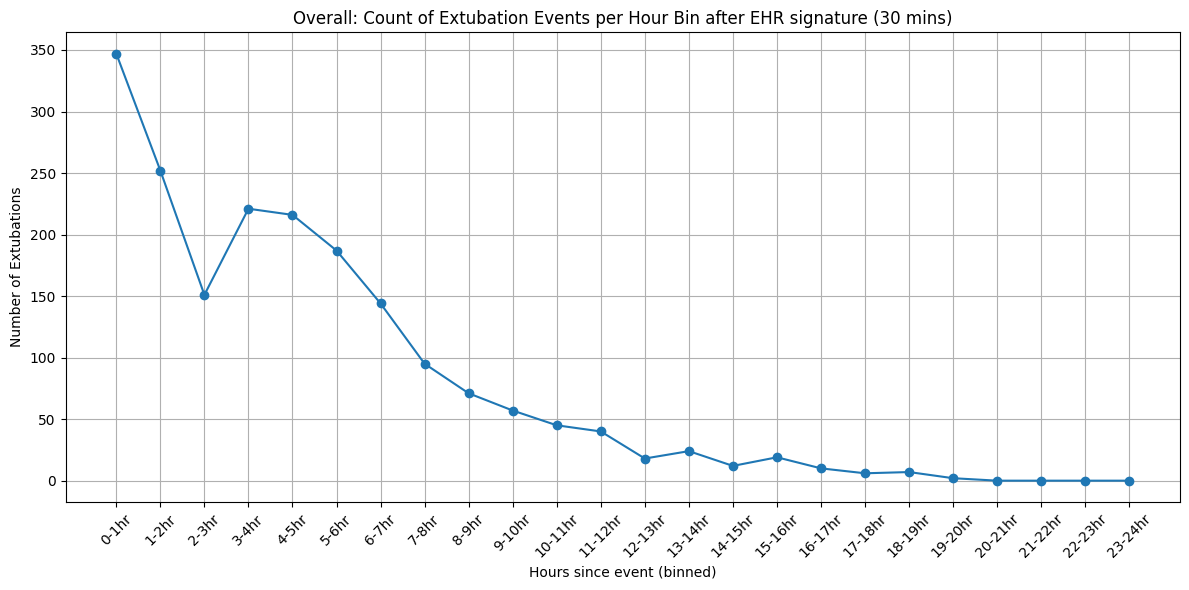

In [11]:
delta_series = final_df.delta_to_extubation_mins.dropna()
# Create bins for each hour till 24 hours
bins = list(range(0, 24*60 + 1, 60))  # from 0 to 1440 minutes (24 hrs) with 60-min intervals
labels = [f'{i}-{i+1}hr' for i in range(24)]  # Label bins as '0-1hr', '1-2hr', ..., '23-24hr'
delta_binned = pd.cut(delta_series, bins=bins, labels=labels, right=False)

# Count the number of entries in each bin
rush_counts = delta_binned.value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(rush_counts.index, rush_counts.values, marker='o')
plt.title('Overall: Count of Extubation Events per Hour Bin after EHR signature (30 mins)')
plt.xlabel('Hours since event (binned)')
plt.ylabel('Number of Extubations')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

## Results Section

In [12]:
final_df['sbt_bkp'] = final_df['sbt_delivery_pass_fail']
final_df['sbt_delivery_pass_fail'] = final_df['sbt_delivery_pass_fail'].map({0:1,1:1})
final_df['sbt_screen_pass_fail'] = final_df['sbt_screen_pass_fail'].map({0:1,1:1})

#fill forward reason of flip fail
final_df['flip_skip_reason'] = (
    final_df.groupby('hosp_id_day_key')['flip_skip_reason']
    .transform(lambda x: x.ffill().bfill())
)

In [13]:
# Ensure the specified columns are treated as datetime before calculating percentages
datetime_columns = [
    'EHR_Delivery_2mins',
    'EHR_Delivery_30mins'
]

for col in datetime_columns:
    if col in final_df.columns:
        final_df[col] = final_df[col].notna().astype(int)

In [14]:
# Group and aggregate the DataFrame including the extubation check
grouped_df = final_df.groupby('hosp_id_day_key').agg({
    'hospitalization_id' : 'first',
    'hospital_id': lambda x: x.dropna().iloc[-1] if x.dropna().size > 0 else np.nan,
    'eligible_day': 'max',
    'EHR_Delivery_2mins': 'max',
    'EHR_Delivery_30mins': 'max',
    'sat_screen_pass_fail': 'max',
    'sat_delivery_pass_fail': 'max',
    'sbt_screen_pass_fail': 'max',
    'sbt_delivery_pass_fail': 'max',
    'flag_2_45_extubated': 'max',  # Uncomment if needed
    'flip_skip_reason': lambda x: x.dropna().iloc[-1] if x.dropna().size > 0 else np.nan,
    'extubated': 'max'
}).reset_index()

# Rename the aggregated device_category column to extubated and fill NaN values
mat_df = grouped_df[grouped_df['eligible_day']==1]

#### Basic counts

In [15]:
# Drop NA hospital_ids and get unique ones
hospital_ids = grouped_df['hospital_id'].dropna().unique()

# Container for summary rows
summary_data = []

# Loop over hospitals and compute stats
for hosp in hospital_ids:
    # Filter data for the hospital and eligible days
    df_hosp = grouped_df[grouped_df['hospital_id'] == hosp]
    df_eligible = df_hosp[df_hosp['eligible_day'] == 1]

    # Calculate condition-specific sets (unique hosp_id_day_keys)
    sbt_S = set(df_eligible[df_eligible['sbt_screen_pass_fail'] == 1]['hosp_id_day_key'].unique())
    sbt_D = set(df_eligible[df_eligible['sbt_delivery_pass_fail'] == 1]['hosp_id_day_key'].unique())
    ehr_2min = set(df_eligible[df_eligible['EHR_Delivery_2mins'] == 1]['hosp_id_day_key'].unique())
    ehr_30min = set(df_eligible[df_eligible['EHR_Delivery_30mins'] == 1]['hosp_id_day_key'].unique())
    ehr_extubated = set(df_eligible[df_eligible['extubated'] == 1]['hosp_id_day_key'].unique())
    ehr_2min_45min_extubated = set(df_eligible[df_eligible['flag_2_45_extubated'] == 1]['hosp_id_day_key'].unique())

    # Append aggregated counts to summary list
    summary_data.append({
        'hospital_id': hosp,
        'sbt_screen_pass': len(sbt_S),
        'sbt_delivery_pass': len(sbt_D),
        'ehr_2min': len(ehr_2min),
        'ehr_30min': len(ehr_30min),
        'extubated': len(ehr_extubated),
        'ehr_2min_45min_extubated': len(ehr_2min_45min_extubated)
    })

    # Optionally print the stats
    print(f"\nHospital ID: {hosp}")
    print(f"  SBT Screen Pass: {len(sbt_S)}")
    print(f"  SBT Delivery Pass: {len(sbt_D)}")
    print(f"  EHR 2-min Delivery: {len(ehr_2min)}")
    print(f"  EHR 30-min Delivery: {len(ehr_30min)}")
    print(f"  Extubated: {len(ehr_extubated)}")
    print(f"  ehr_2min_45min_extubated: {len(ehr_2min_45min_extubated)}")

# Convert summary list to DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df

summary_df.to_csv(f"{directory_path}/hospital_sbt_ehr_summary.csv", index=False)


Hospital ID: RUMC
  SBT Screen Pass: 6250
  SBT Delivery Pass: 4807
  EHR 2-min Delivery: 5631
  EHR 30-min Delivery: 5032
  Extubated: 2560
  ehr_2min_45min_extubated: 301


##### vs SBT flag

In [16]:
hospital_ids = mat_df['hospital_id'].unique()
mat_df['sbt_delivery_pass_fail'] = mat_df['sbt_delivery_pass_fail'].fillna(0)

for hosp in hospital_ids:
    # Filter the DataFrame for the current hospital
    df_hosp = mat_df[mat_df['hospital_id'] == hosp]
    
    # Create the confusion matrix using pd.crosstab
    conf_matrix = pd.crosstab(df_hosp['EHR_Delivery_2mins'], df_hosp['sbt_delivery_pass_fail'])
    
    # Calculate percentages for each cell
    conf_matrix_percent = conf_matrix / conf_matrix.values.sum() * 100
    
    # Create annotation labels that combine count and percentage
    annot = conf_matrix.astype(str) + "\n" + conf_matrix_percent.round(1).astype(str) + "%"
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=annot, fmt='', cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel("SBT Delivery in Flowsheet")
    plt.ylabel("EHR Delivery in 2 minutes")
    plt.title(f"Confusion Matrix for Hospital {hosp}")
    # Save the plot as a PNG file
    plt.savefig(f"{directory_path}/confusion_matrix_{hosp}_by_SBT.png")
    plt.close()  # Close the plot to free memory
    
    # Extract ground truth and predictions for the current hospital
    y_true = df_hosp['EHR_Delivery_2mins']
    y_pred = df_hosp['sbt_delivery_pass_fail']
    
    # Compute the confusion matrix and extract TP, FP, FN, TN
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate individual metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    # Print metrics for current hospital (optional)
    print(f"Hospital ID: {hosp}")
    print(f"Accuracy    : {accuracy:.3f}")
    print(f"Precision   : {precision:.3f}")
    print(f"Recall      : {recall:.3f}")
    print(f"F1 Score    : {f1:.3f}")
    print(f"Specificity : {specificity:.3f}\n")
    
    # Create a dictionary with the computed metrics
    metrics_dict = {
        "True Positives (TP)": tp,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "True Negatives (TN)": tn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Specificity": specificity
    }

    # Build a DataFrame to store the metrics
    df_metrics = pd.DataFrame(list(metrics_dict.items()), columns=["Metric", "Value"])
    
    # Save the metrics DataFrame as a CSV file
    df_metrics.to_csv(f"{directory_path}/EHR_vs_SBT_metrics_{hosp}.csv", index=False)
    print(hosp,df_metrics)

Hospital ID: RUMC
Accuracy    : 0.852
Precision   : 0.903
Recall      : 0.771
F1 Score    : 0.832
Specificity : 0.925

RUMC                  Metric        Value
0   True Positives (TP)  4343.000000
1  False Positives (FP)   464.000000
2  False Negatives (FN)  1288.000000
3   True Negatives (TN)  5738.000000
4              Accuracy     0.851939
5             Precision     0.903474
6                Recall     0.771266
7              F1 Score     0.832152
8           Specificity     0.925185


##### vs extubated

In [17]:
hospital_ids = mat_df['hospital_id'].unique()
mat_df['extubated'] =mat_df['extubated'].fillna(0)
for hosp in hospital_ids:
    # Filter the DataFrame for the current hospital
    df_hosp = mat_df[mat_df['hospital_id'] == hosp]
    
    # Create the confusion matrix using pd.crosstab
    conf_matrix = pd.crosstab(df_hosp['EHR_Delivery_2mins'], df_hosp['extubated'])
    
    # Calculate percentages for each cell
    conf_matrix_percent = conf_matrix / conf_matrix.values.sum() * 100
    
    # Create annotation labels that combine count and percentage
    annot = conf_matrix.astype(str) + "\n" + conf_matrix_percent.round(1).astype(str) + "%"
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=annot, fmt='', cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel("extubated")
    plt.ylabel("EHR Delivery in 2 minutes")
    plt.title(f"Confusion Matrix for Hospital {hosp}")
    # Save the plot as a PNG file
    plt.savefig(f"{directory_path}/confusion_matrix_{hosp}_by_extubated.png")
    plt.close()  # Close the plot to free memory
    
    # Extract ground truth and predictions for the current hospital
    y_true = df_hosp['EHR_Delivery_2mins']
    y_pred = df_hosp['extubated']
    
    # Compute the confusion matrix and extract TP, FP, FN, TN
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate individual metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    # Print metrics for current hospital (optional)
    print(f"Hospital ID: {hosp}")
    print(f"Accuracy    : {accuracy:.3f}")
    print(f"Precision   : {precision:.3f}")
    print(f"Recall      : {recall:.3f}")
    print(f"F1 Score    : {f1:.3f}")
    print(f"Specificity : {specificity:.3f}\n")
    
    # Create a dictionary with the computed metrics
    metrics_dict = {
        "True Positives (TP)": tp,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "True Negatives (TN)": tn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Specificity": specificity
    }
    
    # Build a DataFrame to store the metrics
    df_metrics = pd.DataFrame(list(metrics_dict.items()), columns=["Metric", "Value"])
    
    # Save the metrics DataFrame as a CSV file
    df_metrics.to_csv(f"{directory_path}/EHR_VS_EXTUBATED_metrics_{hosp}.csv", index=False)
    print(hosp,df_metrics)

Hospital ID: RUMC
Accuracy    : 0.681
Precision   : 0.864
Recall      : 0.393
F1 Score    : 0.540
Specificity : 0.944

RUMC                  Metric        Value
0   True Positives (TP)  2211.000000
1  False Positives (FP)   349.000000
2  False Negatives (FN)  3420.000000
3   True Negatives (TN)  5853.000000
4              Accuracy     0.681484
5             Precision     0.863672
6                Recall     0.392648
7              F1 Score     0.539861
8           Specificity     0.943728


##### EHR 30 vs Extubated

In [18]:
hospital_ids = mat_df['hospital_id'].unique()
mat_df['extubated'] =mat_df['extubated'].fillna(0)
for hosp in hospital_ids:
    # Filter the DataFrame for the current hospital
    df_hosp = mat_df[mat_df['hospital_id'] == hosp]
    
    # Create the confusion matrix using pd.crosstab
    conf_matrix = pd.crosstab(df_hosp['EHR_Delivery_30mins'], df_hosp['extubated'])
    
    # Calculate percentages for each cell
    conf_matrix_percent = conf_matrix / conf_matrix.values.sum() * 100
    
    # Create annotation labels that combine count and percentage
    annot = conf_matrix.astype(str) + "\n" + conf_matrix_percent.round(1).astype(str) + "%"
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=annot, fmt='', cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel("extubated")
    plt.ylabel("EHR Delivery in 30 minutes")
    plt.title(f"Confusion Matrix for Hospital {hosp}")
    # Save the plot as a PNG file
    plt.savefig(f"{directory_path}/ehr_30_confusion_matrix_{hosp}_by_extubated.png")
    plt.close()  # Close the plot to free memory
    
    # Extract ground truth and predictions for the current hospital
    y_true = df_hosp['EHR_Delivery_30mins']
    y_pred = df_hosp['extubated']
    
    # Compute the confusion matrix and extract TP, FP, FN, TN
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate individual metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    # Print metrics for current hospital (optional)
    print(f"Hospital ID: {hosp}")
    print(f"Accuracy    : {accuracy:.3f}")
    print(f"Precision   : {precision:.3f}")
    print(f"Recall      : {recall:.3f}")
    print(f"F1 Score    : {f1:.3f}")
    print(f"Specificity : {specificity:.3f}\n")
    
    # Create a dictionary with the computed metrics
    metrics_dict = {
        "True Positives (TP)": tp,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "True Negatives (TN)": tn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Specificity": specificity
    }
    
    # Build a DataFrame to store the metrics
    df_metrics = pd.DataFrame(list(metrics_dict.items()), columns=["Metric", "Value"])
    
    # Save the metrics DataFrame as a CSV file
    df_metrics.to_csv(f"{directory_path}/EHR_30_VS_EXTUBATED_metrics_{hosp}.csv", index=False)
    print(hosp,df_metrics)

Hospital ID: RUMC
Accuracy    : 0.704
Precision   : 0.798
Recall      : 0.406
F1 Score    : 0.538
Specificity : 0.924

RUMC                  Metric        Value
0   True Positives (TP)  2044.000000
1  False Positives (FP)   516.000000
2  False Negatives (FN)  2988.000000
3   True Negatives (TN)  6285.000000
4              Accuracy     0.703879
5             Precision     0.798438
6                Recall     0.406200
7              F1 Score     0.538462
8           Specificity     0.924129


##### EHR 30 VS SBT

In [19]:
hospital_ids = mat_df['hospital_id'].unique()
mat_df['sbt_delivery_pass_fail'] = mat_df['sbt_delivery_pass_fail'].fillna(0)

for hosp in hospital_ids:
    # Filter the DataFrame for the current hospital
    df_hosp = mat_df[mat_df['hospital_id'] == hosp]
    
    # Create the confusion matrix using pd.crosstab
    conf_matrix = pd.crosstab(df_hosp['EHR_Delivery_30mins'], df_hosp['sbt_delivery_pass_fail'])
    
    # Calculate percentages for each cell
    conf_matrix_percent = conf_matrix / conf_matrix.values.sum() * 100
    
    # Create annotation labels that combine count and percentage
    annot = conf_matrix.astype(str) + "\n" + conf_matrix_percent.round(1).astype(str) + "%"
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=annot, fmt='', cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel("SBT Delivery in Flowsheet")
    plt.ylabel("EHR Delivery in 30 minutes")
    plt.title(f"Confusion Matrix for Hospital {hosp}")
    # Save the plot as a PNG file
    plt.savefig(f"{directory_path}/ehr_30_confusion_matrix_{hosp}_by_SBT.png")
    plt.close()  # Close the plot to free memory
    
    # Extract ground truth and predictions for the current hospital
    y_true = df_hosp['EHR_Delivery_30mins']
    y_pred = df_hosp['sbt_delivery_pass_fail']
    
    # Compute the confusion matrix and extract TP, FP, FN, TN
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate individual metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    # Print metrics for current hospital (optional)
    print(f"Hospital ID: {hosp}")
    print(f"Accuracy    : {accuracy:.3f}")
    print(f"Precision   : {precision:.3f}")
    print(f"Recall      : {recall:.3f}")
    print(f"F1 Score    : {f1:.3f}")
    print(f"Specificity : {specificity:.3f}\n")
    
    # Create a dictionary with the computed metrics
    metrics_dict = {
        "True Positives (TP)": tp,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "True Negatives (TN)": tn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Specificity": specificity
    }

    # Build a DataFrame to store the metrics
    df_metrics = pd.DataFrame(list(metrics_dict.items()), columns=["Metric", "Value"])
    
    # Save the metrics DataFrame as a CSV file
    df_metrics.to_csv(f"{directory_path}/EHR_30_vs_SBT_metrics_{hosp}.csv", index=False)
    print(hosp,df_metrics)

Hospital ID: RUMC
Accuracy    : 0.813
Precision   : 0.794
Recall      : 0.758
F1 Score    : 0.776
Specificity : 0.854

RUMC                  Metric        Value
0   True Positives (TP)  3816.000000
1  False Positives (FP)   991.000000
2  False Negatives (FN)  1216.000000
3   True Negatives (TN)  5810.000000
4              Accuracy     0.813488
5             Precision     0.793842
6                Recall     0.758347
7              F1 Score     0.775689
8           Specificity     0.854286


#### fail compared to SBT

In [20]:
hospital_ids = mat_df['hospital_id'].unique()

for hosp in hospital_ids:
    # -------------------------------
    # Filter the data for the current hospital
    # -------------------------------
    mat_hosp = mat_df[mat_df['hospital_id'] == hosp]
    
    # -------------------------------
    # Step 1: Extract filtered keys from mat_hosp
    # -------------------------------
    filtered_keys = mat_hosp.loc[
        (mat_hosp['EHR_Delivery_2mins'] == 0) & (mat_hosp['sbt_delivery_pass_fail'] == 1),
        'hosp_id_day_key'
    ].unique()
    
    # -------------------------------
    # Step 2: Filter final_hosp using these keys
    # -------------------------------
    final_filtered_df = final_df.loc[
        (final_df['sbt_delivery_pass_fail'] == 1) & 
        (final_df['hosp_id_day_key'].isin(filtered_keys))
    ]
    
    final_filtered_df = final_filtered_df.sort_values('event_time')
    final_filtered_df = final_filtered_df.drop_duplicates(subset='hosp_id_day_key', keep='first')
    
    print(f"Hospital: {hosp}, final_filtered_df shape: {final_filtered_df.shape}")
    
    # -------------------------------
    # Work on a copy for filtering steps
    # -------------------------------
    df = final_filtered_df.copy()
    results = []
    
    # ---------------------------------------
    # Step 1: Filter on 'flip_skip_reason'
    # ---------------------------------------
    step1 = df[~df['flip_skip_reason'].isna()]
    results.append({
        'Step': 'Step 1',
        'FilterColumn': 'flip_skip_reason',
        'UniqueKeys': step1['hosp_id_day_key'].nunique(),
        'RowCount': step1.shape[0],
        'ValueCounts': step1['flip_skip_reason'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step1['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 2: Filter on 'cond_device_imv'
    # ---------------------------------------
    step2 = df[~df['cond_device_imv'].isna()]
    results.append({
        'Step': 'Step 2',
        'FilterColumn': 'cond_device_imv',
        'UniqueKeys': step2['hosp_id_day_key'].nunique(),
        'RowCount': step2.shape[0],
        'ValueCounts': step2['cond_device_imv'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step2['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 3: Filter on 'cond_location_icu'
    # ---------------------------------------
    step3 = df[~df['cond_location_icu'].isna()]
    results.append({
        'Step': 'Step 3',
        'FilterColumn': 'cond_location_icu',
        'UniqueKeys': step3['hosp_id_day_key'].nunique(),
        'RowCount': step3.shape[0],
        'ValueCounts': step3['cond_location_icu'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step3['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 4: Filter on 'cond_peep_set_le8'
    # ---------------------------------------
    step4 = df[~df['cond_peep_set_le8'].isna()]
    results.append({
        'Step': 'Step 4',
        'FilterColumn': 'cond_peep_set_le8',
        'UniqueKeys': step4['hosp_id_day_key'].nunique(),
        'RowCount': step4.shape[0],
        'ValueCounts': step4['cond_peep_set_le8'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step4['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 5: Filter on 'cond_ps_set_le8'
    # ---------------------------------------
    step5 = df[~df['cond_ps_set_le8'].isna()]
    results.append({
        'Step': 'Step 5',
        'FilterColumn': 'cond_ps_set_le8',
        'UniqueKeys': step5['hosp_id_day_key'].nunique(),
        'RowCount': step5.shape[0],
        'ValueCounts': step5['cond_ps_set_le8'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step5['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 6: Filter on 'cond_mode_ps_cpap'
    # ---------------------------------------
    step6 = df[~df['cond_mode_ps_cpap'].isna()]
    results.append({
        'Step': 'Step 6',
        'FilterColumn': 'cond_mode_ps_cpap',
        'UniqueKeys': step6['hosp_id_day_key'].nunique(),
        'RowCount': step6.shape[0],
        'ValueCounts': step6['cond_mode_ps_cpap'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step6['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 7: Remaining (unmatched) rows
    # ---------------------------------------
    step7 = df.copy()
    results.append({
        'Step': 'Step 7 (Unmatched)',
        'FilterColumn': None,
        'UniqueKeys': step7['hosp_id_day_key'].nunique(),
        'RowCount': step7.shape[0],
        'ValueCounts': None
    })
    
    # ---------------------------------------
    # Create Detailed Step-by-Step Summary DataFrame
    # ---------------------------------------
    detailed_summary_df = pd.DataFrame(results)
    
    # Calculate total_failures as the sum of UniqueKeys across all steps for this hospital
    total_failures = detailed_summary_df['UniqueKeys'].sum()
    
   
    
    # Add "% Per 100" and "% of Total" columns
    detailed_summary_df['% by eligible_days'] = detailed_summary_df['UniqueKeys'].apply(
        lambda x: round((x / eligible_days) * 100, 2)
    )
    detailed_summary_df['% of Total'] = detailed_summary_df['UniqueKeys'].apply(
        lambda x: round((x / total_failures) * 100, 2) if total_failures != 0 else 0
    )
    
    # ---------------------------------------
    # Save the detailed summary DataFrame as a CSV file for the current hospital
    # ---------------------------------------
    output_filename = f"{directory_path}/EHR_VS_SBT_failure_dependent_summary_{hosp}.csv"
    detailed_summary_df.to_csv(output_filename, index=False)
    print(f"Saved detailed summary for hospital {hosp} to {output_filename}\n")
    print(hosp,detailed_summary_df)
    print()

    # ============================================================
    # B. Independent Filtering Summary (Apply each filter independently)
    # ============================================================
    ind_step1 = final_filtered_df[~final_filtered_df['flip_skip_reason'].isna()]
    ind_step2 = final_filtered_df[~final_filtered_df['cond_device_imv'].isna()]
    ind_step3 = final_filtered_df[~final_filtered_df['cond_location_icu'].isna()]
    ind_step4 = final_filtered_df[~final_filtered_df['cond_peep_set_le8'].isna()]
    ind_step5 = final_filtered_df[~final_filtered_df['cond_ps_set_le8'].isna()]
    ind_step6 = final_filtered_df[~final_filtered_df['cond_mode_ps_cpap'].isna()]
    
    # Determine the union of keys matched by any filter
    matched_keys = set().union(
        ind_step1['hosp_id_day_key'],
        ind_step2['hosp_id_day_key'],
        ind_step3['hosp_id_day_key'],
        ind_step4['hosp_id_day_key'],
        ind_step5['hosp_id_day_key'],
        ind_step6['hosp_id_day_key']
    )
    # Unmatched keys: those not included in any of the independent filters
    ind_step7 = final_filtered_df[~final_filtered_df['hosp_id_day_key'].isin(matched_keys)]
    
    # Compute unique key counts per filter
    failure_counts = {
        'flip_skip_reason': ind_step1['hosp_id_day_key'].nunique(),
        'cond_device_imv': ind_step2['hosp_id_day_key'].nunique(),
        'cond_location_icu': ind_step3['hosp_id_day_key'].nunique(),
        'cond_peep_set_le8': ind_step4['hosp_id_day_key'].nunique(),
        'cond_ps_set_le8': ind_step5['hosp_id_day_key'].nunique(),
        'cond_mode_ps_cpap': ind_step6['hosp_id_day_key'].nunique(),
        'unmatched': ind_step7['hosp_id_day_key'].nunique()
    }
    
    # Compute value counts for each filter column
    value_counts_map = {
        'flip_skip_reason': ind_step1['flip_skip_reason'].value_counts(dropna=False).to_dict(),
        'cond_device_imv': ind_step2['cond_device_imv'].value_counts(dropna=False).to_dict(),
        'cond_location_icu': ind_step3['cond_location_icu'].value_counts(dropna=False).to_dict(),
        'cond_peep_set_le8': ind_step4['cond_peep_set_le8'].value_counts(dropna=False).to_dict(),
        'cond_ps_set_le8': ind_step5['cond_ps_set_le8'].value_counts(dropna=False).to_dict(),
        'cond_mode_ps_cpap': ind_step6['cond_mode_ps_cpap'].value_counts(dropna=False).to_dict(),
        'unmatched': None
    }
    
    total_failures_ind = sum(failure_counts.values())
    summary_data = []
    for reason, count in failure_counts.items():
        summary_data.append({
            'Failure Reason': reason,
            'Count': count,
            '% by eligible_days': round((count / eligible_days) * 100, 2),
            '% of Total (out of total failed cases)': round((count / total_failures_ind) * 100, 2) if total_failures_ind else 0,
            'Value Counts': value_counts_map[reason]
        })
    
    independent_summary_df = pd.DataFrame(summary_data)
    independent_summary_df = independent_summary_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    
    ind_output_filename = f"{directory_path}/EHR_VS_SBT_failure_independent_summary_hospital_{hosp}.csv"
    independent_summary_df.to_csv(ind_output_filename, index=False)
    print(f"Saved independent summary for hospital {hosp} to {ind_output_filename}\n")
    print(hosp, independent_summary_df)
    print()

Hospital: RUMC, final_filtered_df shape: (464, 91)
Saved detailed summary for hospital RUMC to ../output/final/RUSH\standard/EHR_VS_SBT_failure_dependent_summary_RUMC.csv

RUMC                  Step       FilterColumn  UniqueKeys  RowCount  \
0              Step 1   flip_skip_reason         429       429   
1              Step 2    cond_device_imv           2         2   
2              Step 3  cond_location_icu           0         0   
3              Step 4  cond_peep_set_le8          30        30   
4              Step 5    cond_ps_set_le8           1         1   
5              Step 6  cond_mode_ps_cpap           2         2   
6  Step 7 (Unmatched)               None           0         0   

                                         ValueCounts  % by eligible_days  \
0  {'Flip before IMV_Controlled_met_time': 296, '...                3.63   
1                               {'nasal cannula': 2}                0.02   
2                                                 {}              

#### Failure compared to extubated

In [21]:
hospital_ids = mat_df['hospital_id'].unique()

for hosp in hospital_ids:
    # -------------------------------
    # Filter the data for the current hospital
    # -------------------------------
    mat_hosp = mat_df[mat_df['hospital_id'] == hosp]
    
    # -------------------------------
    # Step 1: Extract filtered keys from mat_hosp
    # -------------------------------
    filtered_keys = mat_hosp.loc[
        (mat_hosp['EHR_Delivery_2mins'] == 0) & (mat_hosp['extubated'] == 1),
        'hosp_id_day_key'
    ].unique()
    
    # -------------------------------
    # Step 2: Filter final_hosp using these keys
    # -------------------------------
    final_filtered_df = final_df.loc[
        (final_df['extubated'] == 1) & 
        (final_df['hosp_id_day_key'].isin(filtered_keys))
    ]
    
    final_filtered_df = final_filtered_df.sort_values('event_time')
    final_filtered_df = final_filtered_df.drop_duplicates(subset='hosp_id_day_key', keep='first')
    
    print(f"Hospital: {hosp}, final_filtered_df shape: {final_filtered_df.shape}")
    
    # -------------------------------
    # Work on a copy for filtering steps
    # -------------------------------
    df = final_filtered_df.copy()
    results = []
    
    # ---------------------------------------
    # Step 1: Filter on 'flip_skip_reason'
    # ---------------------------------------
    step1 = df[~df['flip_skip_reason'].isna()]
    results.append({
        'Step': 'Step 1',
        'FilterColumn': 'flip_skip_reason',
        'UniqueKeys': step1['hosp_id_day_key'].nunique(),
        'RowCount': step1.shape[0],
        'ValueCounts': step1['flip_skip_reason'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step1['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 2: Filter on 'cond_device_imv'
    # ---------------------------------------
    step2 = df[~df['cond_device_imv'].isna()]
    results.append({
        'Step': 'Step 2',
        'FilterColumn': 'cond_device_imv',
        'UniqueKeys': step2['hosp_id_day_key'].nunique(),
        'RowCount': step2.shape[0],
        'ValueCounts': step2['cond_device_imv'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step2['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 3: Filter on 'cond_location_icu'
    # ---------------------------------------
    step3 = df[~df['cond_location_icu'].isna()]
    results.append({
        'Step': 'Step 3',
        'FilterColumn': 'cond_location_icu',
        'UniqueKeys': step3['hosp_id_day_key'].nunique(),
        'RowCount': step3.shape[0],
        'ValueCounts': step3['cond_location_icu'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step3['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 4: Filter on 'cond_peep_set_le8'
    # ---------------------------------------
    step4 = df[~df['cond_peep_set_le8'].isna()]
    results.append({
        'Step': 'Step 4',
        'FilterColumn': 'cond_peep_set_le8',
        'UniqueKeys': step4['hosp_id_day_key'].nunique(),
        'RowCount': step4.shape[0],
        'ValueCounts': step4['cond_peep_set_le8'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step4['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 5: Filter on 'cond_ps_set_le8'
    # ---------------------------------------
    step5 = df[~df['cond_ps_set_le8'].isna()]
    results.append({
        'Step': 'Step 5',
        'FilterColumn': 'cond_ps_set_le8',
        'UniqueKeys': step5['hosp_id_day_key'].nunique(),
        'RowCount': step5.shape[0],
        'ValueCounts': step5['cond_ps_set_le8'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step5['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 6: Filter on 'cond_mode_ps_cpap'
    # ---------------------------------------
    step6 = df[~df['cond_mode_ps_cpap'].isna()]
    results.append({
        'Step': 'Step 6',
        'FilterColumn': 'cond_mode_ps_cpap',
        'UniqueKeys': step6['hosp_id_day_key'].nunique(),
        'RowCount': step6.shape[0],
        'ValueCounts': step6['cond_mode_ps_cpap'].value_counts(dropna=False).to_dict()
    })
    df = df[~df['hosp_id_day_key'].isin(step6['hosp_id_day_key'])]
    
    # ---------------------------------------
    # Step 7: Remaining (unmatched) rows
    # ---------------------------------------
    step7 = df.copy()
    results.append({
        'Step': 'Step 7 (No Value)',
        'FilterColumn': None,
        'UniqueKeys': step7['hosp_id_day_key'].nunique(),
        'RowCount': step7.shape[0],
        'ValueCounts': None
    })
    
    # ---------------------------------------
    # Create Detailed Step-by-Step Summary DataFrame
    # ---------------------------------------
    detailed_summary_df = pd.DataFrame(results)
    
    # Calculate total_failures as the sum of UniqueKeys across all steps for this hospital
    total_failures = detailed_summary_df['UniqueKeys'].sum()
    
   
    
    # Add "% Per 100" and "% of Total" columns
    detailed_summary_df['% by eligible_days'] = detailed_summary_df['UniqueKeys'].apply(
        lambda x: round((x / eligible_days) * 100, 2)
    )
    detailed_summary_df['% of Total'] = detailed_summary_df['UniqueKeys'].apply(
        lambda x: round((x / total_failures) * 100, 2) if total_failures != 0 else 0
    )
    
    # ---------------------------------------
    # Save the detailed summary DataFrame as a CSV file for the current hospital
    # ---------------------------------------
    output_filename = f"{directory_path}/EHR_VS_EXTUBATED_failure_dependent_summary_{hosp}.csv"
    detailed_summary_df.to_csv(output_filename, index=False)
    print(f"Saved detailed summary for hospital {hosp} to {output_filename}\n")
    print(hosp,detailed_summary_df)
    print()

    # ============================================================
    # B. Independent Filtering Summary (Apply each filter independently)
    # ============================================================
    ind_step1 = final_filtered_df[~final_filtered_df['flip_skip_reason'].isna()]
    ind_step2 = final_filtered_df[~final_filtered_df['cond_device_imv'].isna()]
    ind_step3 = final_filtered_df[~final_filtered_df['cond_location_icu'].isna()]
    ind_step4 = final_filtered_df[~final_filtered_df['cond_peep_set_le8'].isna()]
    ind_step5 = final_filtered_df[~final_filtered_df['cond_ps_set_le8'].isna()]
    ind_step6 = final_filtered_df[~final_filtered_df['cond_mode_ps_cpap'].isna()]
    
    # Determine the union of keys matched by any filter
    matched_keys = set().union(
        ind_step1['hosp_id_day_key'],
        ind_step2['hosp_id_day_key'],
        ind_step3['hosp_id_day_key'],
        ind_step4['hosp_id_day_key'],
        ind_step5['hosp_id_day_key'],
        ind_step6['hosp_id_day_key']
    )
    # Unmatched keys: those not included in any of the independent filters
    ind_step7 = final_filtered_df[~final_filtered_df['hosp_id_day_key'].isin(matched_keys)]
    
    # Compute unique key counts per filter
    failure_counts = {
        'flip_skip_reason': ind_step1['hosp_id_day_key'].nunique(),
        'cond_device_imv': ind_step2['hosp_id_day_key'].nunique(),
        'cond_location_icu': ind_step3['hosp_id_day_key'].nunique(),
        'cond_peep_set_le8': ind_step4['hosp_id_day_key'].nunique(),
        'cond_ps_set_le8': ind_step5['hosp_id_day_key'].nunique(),
        'cond_mode_ps_cpap': ind_step6['hosp_id_day_key'].nunique(),
        'No Value': ind_step7['hosp_id_day_key'].nunique()
    }
    
    # Compute value counts for each filter column
    value_counts_map = {
        'flip_skip_reason': ind_step1['flip_skip_reason'].value_counts(dropna=False).to_dict(),
        'cond_device_imv': ind_step2['cond_device_imv'].value_counts(dropna=False).to_dict(),
        'cond_location_icu': ind_step3['cond_location_icu'].value_counts(dropna=False).to_dict(),
        'cond_peep_set_le8': ind_step4['cond_peep_set_le8'].value_counts(dropna=False).to_dict(),
        'cond_ps_set_le8': ind_step5['cond_ps_set_le8'].value_counts(dropna=False).to_dict(),
        'cond_mode_ps_cpap': ind_step6['cond_mode_ps_cpap'].value_counts(dropna=False).to_dict(),
        'No Value': None
    }
    
    total_failures_ind = sum(failure_counts.values())
    summary_data = []
    for reason, count in failure_counts.items():
        summary_data.append({
            'Failure Reason': reason,
            'Count': count,
            '% by eligible_days': round((count / eligible_days) * 100, 2),
            '% of Total (out of total failed cases)': round((count / total_failures_ind) * 100, 2) if total_failures_ind else 0,
            'Value Counts': value_counts_map[reason]
        })
    
    independent_summary_df = pd.DataFrame(summary_data)
    independent_summary_df = independent_summary_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    
    ind_output_filename = f"{directory_path}/EHR_VS_EXTUBATED_failure_independent_summary_{hosp}.csv"
    independent_summary_df.to_csv(ind_output_filename, index=False)
    print(f"Saved independent summary for hospital {hosp} to {ind_output_filename}\n")
    print(hosp, independent_summary_df)
    print()

Hospital: RUMC, final_filtered_df shape: (349, 91)
Saved detailed summary for hospital RUMC to ../output/final/RUSH\standard/EHR_VS_EXTUBATED_failure_dependent_summary_RUMC.csv

RUMC                 Step       FilterColumn  UniqueKeys  RowCount  \
0             Step 1   flip_skip_reason          79        79   
1             Step 2    cond_device_imv           0         0   
2             Step 3  cond_location_icu           9         9   
3             Step 4  cond_peep_set_le8          25        25   
4             Step 5    cond_ps_set_le8          87        87   
5             Step 6  cond_mode_ps_cpap         146       146   
6  Step 7 (No Value)               None           3         3   

                                         ValueCounts  % by eligible_days  \
0  {'Flip before IMV_Controlled_met_time': 53, 'e...                0.67   
1                                                 {}                0.00   
2                       {'procedural': 6, 'ward': 3}                

#### Plots

In [22]:
hospital_ids = final_df['hospital_id'].dropna().unique()

# This list will hold the summary data for each hospital
hospital_summary_list = []

for hosp in hospital_ids:
    # Filter final_df for the current hospital
    final_hosp = final_df[final_df['hospital_id'] == hosp]
    
    # Extract event times for SBT delivery (pass) and EHR delivery (within 2 mins)
    sbt_d_time =(
    final_hosp[
        (final_hosp['sbt_delivery_pass_fail'] == 1) &
        (final_hosp['eligible_day'] == 1)
    ]
    .sort_values(['hosp_id_day_key', 'event_time'])  # ensure order
    .groupby('hosp_id_day_key', as_index=False)
    .first()[['hosp_id_day_key', 'event_time']]
)
    
    ehr_d_time = final_hosp[
        (final_hosp['EHR_Delivery_2mins'] == 1) & 
        (final_hosp['eligible_day'] == 1)
    ][['hosp_id_day_key', 'event_time']].drop_duplicates()
    
    # Convert event_time to hour values
    sbt_hours = sbt_d_time['event_time'].dt.hour
    ehr_hours = ehr_d_time['event_time'].dt.hour

    # Create overlay histogram plot for the current hospital
    plt.figure(figsize=(10, 6))
    # Use bins from 0 to 24 (24 bins) to capture each hour of the day
    plt.hist(sbt_hours, bins=range(0, 25), alpha=0.5, label='SBT Delivery Time', edgecolor='black')
    plt.hist(ehr_hours, bins=range(0, 25), alpha=0.5, label='EHR Delivery Time', edgecolor='black')
    plt.xlabel('Hour of Day')
    plt.ylabel('Frequency')
    plt.title(f'Event Time Distribution (Hourly) - Hospital {hosp}')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save the plot for the current hospital
    plt.savefig(f"{directory_path}/event_time_distribution_hospital_{hosp}.png")
    plt.close()
    
    # Build a summary DataFrame for the current hospital:
    # Get counts per hour for each event type
    sbt_counts = sbt_hours.value_counts().sort_index()
    ehr_counts = ehr_hours.value_counts().sort_index()
    
    # Create a DataFrame with all hours 0-23, merging the counts (fill missing with 0)
    hours_df = pd.DataFrame({'hour': range(24)})
    hours_df['SBT_Delivery'] = hours_df['hour'].map(sbt_counts).fillna(0).astype(int)
    hours_df['EHR_Delivery'] = hours_df['hour'].map(ehr_counts).fillna(0).astype(int)
    hours_df['hospital_id'] = hosp
    
    hospital_summary_list.append(hours_df)

# Combine the summary data for all hospitals into one DataFrame
combined_summary_df = pd.concat(hospital_summary_list, ignore_index=True)
combined_summary_df.to_csv(f"{directory_path}/event_time_distribution_summary.csv", index=False)

print("Overlay plots created and summary CSV saved.")

Overlay plots created and summary CSV saved.


In [23]:
hospital_ids = final_df['hospital_id'].dropna().unique()

# This list will hold the summary data for each hospital
hospital_summary_list = []

for hosp in hospital_ids:
    # Filter final_df for the current hospital
    final_hosp = final_df[final_df['hospital_id'] == hosp]
    
    # Extract event times for SBT delivery (pass) and EHR delivery (within 2 mins)
    sbt_d_time = (
    final_hosp[
        (final_hosp['extubated'] == 1) &
        (final_hosp['eligible_day'] == 1)
    ]
    .sort_values(['hosp_id_day_key', 'event_time'])  # ensure order
    .groupby('hosp_id_day_key', as_index=False)
    .first()[['hosp_id_day_key', 'event_time']]
)

    
    ehr_d_time = final_hosp[
        (final_hosp['EHR_Delivery_2mins'] == 1) & 
        (final_hosp['eligible_day'] == 1)
    ][['hosp_id_day_key', 'event_time']].drop_duplicates()
    
    # Convert event_time to hour values
    sbt_hours = sbt_d_time['event_time'].dt.hour
    ehr_hours = ehr_d_time['event_time'].dt.hour

    # Create overlay histogram plot for the current hospital
    plt.figure(figsize=(10, 6))
    # Use bins from 0 to 24 (24 bins) to capture each hour of the day
    plt.hist(sbt_hours, bins=range(0, 25), alpha=0.5, label='Extubated Time', edgecolor='black')
    plt.hist(ehr_hours, bins=range(0, 25), alpha=0.5, label='EHR Delivery Time', edgecolor='black')
    plt.xlabel('Hour of Day')
    plt.ylabel('Frequency')
    plt.title(f'Event Time Distribution (Hourly) - Hospital {hosp}')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save the plot for the current hospital
    plt.savefig(f"{directory_path}/event_time_distribution_hospital_{hosp}_by_ex.png")
    plt.close()
    
    # Build a summary DataFrame for the current hospital:
    # Get counts per hour for each event type
    sbt_counts = sbt_hours.value_counts().sort_index()
    ehr_counts = ehr_hours.value_counts().sort_index()
    
    # Create a DataFrame with all hours 0-23, merging the counts (fill missing with 0)
    hours_df = pd.DataFrame({'hour': range(24)})
    hours_df['SBT_Delivery'] = hours_df['hour'].map(sbt_counts).fillna(0).astype(int)
    hours_df['EHR_Delivery'] = hours_df['hour'].map(ehr_counts).fillna(0).astype(int)
    hours_df['hospital_id'] = hosp
    
    hospital_summary_list.append(hours_df)

# Combine the summary data for all hospitals into one DataFrame
combined_summary_df = pd.concat(hospital_summary_list, ignore_index=True)
combined_summary_df.to_csv(f"{directory_path}/event_time_distribution_summary_by_ex.csv", index=False)

print("Overlay plots created and summary CSV saved.")

Overlay plots created and summary CSV saved.


In [24]:
# --- Calculate statistics from final_df ---

# By n = Days
total_days = final_df['hosp_id_day_key'].nunique()
eligible_days = final_df[final_df['eligible_day'] == 1]['hosp_id_day_key'].nunique()
imv_days = final_df[final_df['device_category'] == 'imv']['hosp_id_day_key'].nunique()
percentage = (eligible_days / imv_days) * 100 if total_days > 0 else 0
imv_icu_days = final_df[
    (final_df['device_category'] == 'imv') & 
    (final_df['location_category'] == 'icu')
]['hosp_id_day_key'].nunique()

# By n = Encounter
h_total_days = final_df['hospitalization_id'].nunique()
h_eligible_days = final_df[final_df['eligible_day'] == 1]['hospitalization_id'].nunique()
h_percentage = (h_eligible_days / h_total_days) * 100 if h_total_days > 0 else 0
h_imv_days = final_df[final_df['device_category'] == 'imv']['hospitalization_id'].nunique()
h_imv_icu_days = final_df[
    (final_df['device_category'] == 'imv') & 
    (final_df['location_category'] == 'icu')
]['hospitalization_id'].nunique()

# --- Calculate statistics from mat_df ---

# Distribution of EHR_Delivery_2mins for extubated == 1 (in percentages)
ehr_delivery_counts = (
    mat_df[mat_df['extubated'] == 1]['EHR_Delivery_2mins']
    .value_counts(normalize=True) * 100
)

# Distribution of sbt_delivery_pass_fail for extubated == 1 (in percentages)
sbt_delivery_counts = (
    mat_df[mat_df['extubated'] == 1]['sbt_delivery_pass_fail']
    .value_counts(normalize=True) * 100
)

# --- Print the statistics ---

print('By n = Days')
print('Total number of days for eval in cohort:', total_days)
print(f"Eligible days: {eligible_days} / {imv_days} ({percentage:.2f}%)")
print('Hospital days with at least one IMV event:', imv_days)
print('Hospital days with at least one IMV & ICU event:', imv_icu_days)

print('\nBy n = Encounter')
print('Total number of encounters for eval in cohort:', h_total_days)
print(f"Eligible encounters: {h_eligible_days} / {h_total_days} ({h_percentage:.2f}%)")
print('Encounters with at least one IMV event:', h_imv_days)
print('Encounters with at least one IMV & ICU event:', h_imv_icu_days)

print('\nEHR_Delivery_2mins distribution (for extubated == 1):')
print(ehr_delivery_counts)

print('\nsbt_delivery_pass_fail distribution (for extubated == 1):')
print(sbt_delivery_counts)

# --- Create a summary DataFrame for the final_df stats ---

stats_data = {
    'Metric': [
        'total_days', 'eligible_days', 'eligible_percentage', 
        'imv_days', 'imv_icu_days', 
        'h_total_days', 'h_eligible_days', 'h_eligible_percentage', 
        'h_imv_days', 'h_imv_icu_days'
    ],
    'Value': [
        total_days, eligible_days, percentage,
        imv_days, imv_icu_days,
        h_total_days, h_eligible_days, h_percentage,
        h_imv_days, h_imv_icu_days
    ]
}

stats_df = pd.DataFrame(stats_data)

# Convert value counts to DataFrames and append to stats_df
ehr_counts_df = ehr_delivery_counts.reset_index()
ehr_counts_df.columns = ['Metric', 'Value']
ehr_counts_df['Metric'] = 'EHR_Delivery_2mins_' + ehr_counts_df['Metric'].astype(str) + '_extubated'

sbt_counts_df = sbt_delivery_counts.reset_index()
sbt_counts_df.columns = ['Metric', 'Value']
sbt_counts_df['Metric'] = 'sbt_delivery_pass_fail_' + sbt_counts_df['Metric'].astype(str) + '_extubated'

# Combine all stats
stats_df = pd.concat([stats_df, ehr_counts_df, sbt_counts_df], ignore_index=True)

print('\nExtended statistics DataFrame with value counts:')
print(stats_df)

# Save to CSV
stats_df.to_csv(f'{directory_path}/stats_df.csv', index=False)


By n = Days
Total number of days for eval in cohort: 61288
Eligible days: 11833 / 18250 (64.84%)
Hospital days with at least one IMV event: 18250
Hospital days with at least one IMV & ICU event: 17154

By n = Encounter
Total number of encounters for eval in cohort: 4176
Eligible encounters: 3156 / 4176 (75.57%)
Encounters with at least one IMV event: 4176
Encounters with at least one IMV & ICU event: 4142

EHR_Delivery_2mins distribution (for extubated == 1):
EHR_Delivery_2mins
1    86.367188
0    13.632812
Name: proportion, dtype: float64

sbt_delivery_pass_fail distribution (for extubated == 1):
sbt_delivery_pass_fail
1.0    80.429688
0.0    19.570312
Name: proportion, dtype: float64

Extended statistics DataFrame with value counts:
                                  Metric         Value
0                             total_days  61288.000000
1                          eligible_days  11833.000000
2                    eligible_percentage     64.838356
3                               imv

In [25]:
mat_hosp[
        (mat_hosp['EHR_Delivery_2mins'] == 0) & (mat_hosp['extubated'] == 1)
    ]['sbt_delivery_pass_fail'].value_counts()

sbt_delivery_pass_fail
0.0    260
1.0     89
Name: count, dtype: int64